/tmp/ipykernel_1020644/2408551404.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


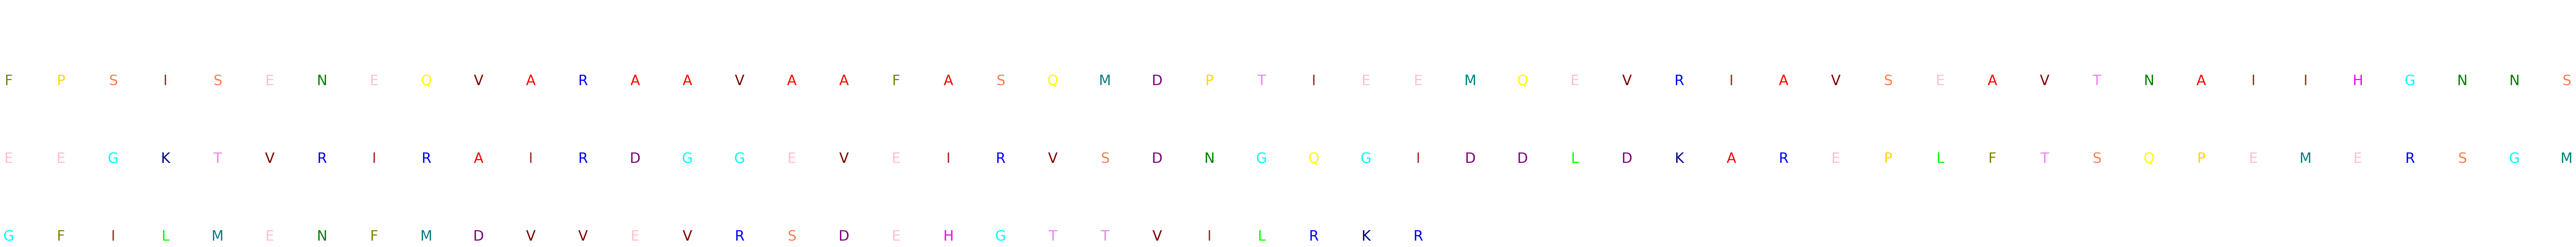

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# The amino acid sequence
sequence = "FPSISENEQVARAAVAAFASQMDPTIEEMQEVRIAVSEAVTNAIIHGNNSEEGKTVRIRAIRDGGEVEIRVSDNGQGIDDLDKAREPLFTSQPEMERSGMGFILMENFMDVVEVRSDEHGTTVILRKR"

# Unique colors for each of the 20 amino acids
amino_acid_colors = {
    'A': 'red',      # Alanine
    'R': 'blue',     # Arginine
    'N': 'green',    # Asparagine
    'D': 'purple',   # Aspartic acid
    'C': 'orange',   # Cysteine
    'Q': 'yellow',   # Glutamine
    'E': 'pink',     # Glutamic acid
    'G': 'cyan',     # Glycine
    'H': 'magenta',  # Histidine
    'I': 'brown',    # Isoleucine
    'L': 'lime',     # Leucine
    'K': 'navy',     # Lysine
    'M': 'teal',     # Methionine
    'F': 'olive',    # Phenylalanine
    'P': 'gold',     # Proline
    'S': 'coral',    # Serine
    'T': 'violet',   # Threonine
    'W': 'gray',     # Tryptophan
    'Y': 'turquoise',# Tyrosine
    'V': 'maroon'    # Valine
}

# Function to break sequence into chunks
def chunk_sequence(seq, chunk_size):
    return [seq[i:i+chunk_size] for i in range(0, len(seq), chunk_size)]

# Split the sequence into chunks of 50 characters each
chunked_sequence = chunk_sequence(sequence, 50)

# Create figure
fig, ax = plt.subplots(figsize=(2, len(chunked_sequence)))

# Visualize the sequence with assigned colors
for row, chunk in enumerate(chunked_sequence):
    for col, amino_acid in enumerate(chunk):
        ax.text(col, -row, amino_acid, color=amino_acid_colors[amino_acid], fontsize=30, ha='center', va='center')

# Remove axis
ax.set_axis_off()

# Add legend for the amino acids and their colors
legend_patches = [mpatches.Patch(color=color, label=aa) for aa, color in amino_acid_colors.items()]
# ax.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.05, 0.115), ncol=10)

# Adjust the figure size to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()
